In [1]:
#%display latex

In [2]:
# sage comes with a built-in pip:
# ~/Programs/SageMath/sage --pip install dill
# installed sage via jupyter kernelspec install --user ./SageMath/local/share/jupyter/kernels/
import dill
import pickle
from transmembrane_lib import *
import textwrap


from scipy.integrate import odeint
from sympy.plotting import plot
from sympy import init_printing
import sympy
from sympy.abc import t
from sympy import Array, Sum, Indexed, IndexedBase, Idx
init_printing()
from sympy.abc import t # x is the independent variable
from sympy import Function, dsolve, Eq, Derivative, sin, cos, symbols, exp, pi, diff, Poly
from sympy.physics.units.systems import SI
from sympy.physics.units import length, mass, acceleration, force
from sympy.physics.units import gravitational_constant as G
from sympy.physics.units.systems.si import dimsys_SI
import sympy.physics.units as units
#import pprint as pps
import sympy
import sympy.physics.units.util as util
from dataclasses import dataclass
from sympy.simplify.radsimp import collect
from sympy.assumptions.refine import refine
from sympy import init_printing
from sympy.simplify.powsimp import powsimp
init_printing()
from scipy.integrate import odeint
from sympy.plotting import plot
from sympy import init_printing
import sympy
from sympy.abc import t
from sympy import Array, Sum, Indexed, IndexedBase, Idx
init_printing()
from sympy.abc import t # x is the independent variable
from sympy import Function, dsolve, Eq, Derivative, sin, cos, symbols, exp, pi, diff, Poly
from sympy import I
virus = default_virus(np.array([]))
host_cell = default_host_cell(np.array([]))

def convexp(name, val):
    return (Eq(sympy.S(name), val, evaluate=False))

def sympy_round(ex1):
    # thanks https://stackoverflow.com/questions/43804701/round-floats-within-an-expression
    ex2 = ex1
    #for a in sympy.preorder_traversal(ex1):
    for a in ex1.args:
        for b in a.args:
            for c in b.args:
                if isinstance(c, sympy.Float):
                    ex2 = ex2.subs(c, round(c, 7))
    return ex2


Terminology

$\lambda$, l, $\sigma$ : conductivity

Sympy can print in Julia with sympy.printing.julia; from sympy import julia_code!!!!

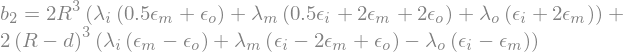

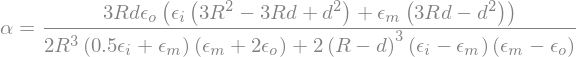

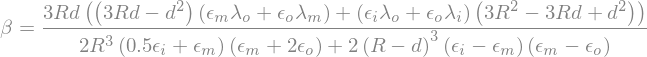

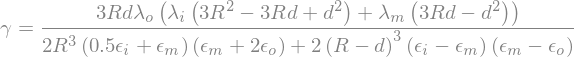

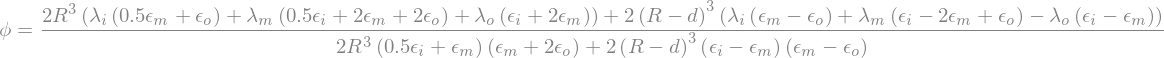

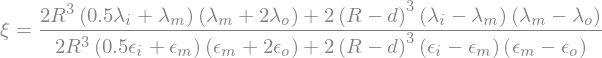

In [3]:
e_o, e_i, e_m = symbols(("epsilon_o", "epsilon_i", "epsilon_m"))

R, l_o, l_i, l_m, d, a_1, a_2, a_3, b_1, b_2, b_3 = symbols("R lambda_o lambda_i lambda_m d a_1 a_2 a_3 b_1 b_2 b_3")

#     e_o = extracellular_permittivity * eps0 # S/m
#     e_i = intracellular_permittivity * eps0 #S/m
#     e_m = membrane_permittivity * eps0 #S/m
#     R = cell_diameter / 2
#     R = R

#     l_o = extracellular_conductivity*Spm # S/m
#     l_i = intracellular_conductivity*Spm #S/m
#     l_m = membrane_conductivity*Spm #S/m

#     d = membrane_thickness

sub1, sub2 = symbols('sub1 sub2')
sub1 = (3 * (R**2) - 3 * d * R + d**2)
sub2 = (3 * d * R - d**2)

a_1 = 3 * d * l_o * ((l_i * (sub1)) + l_m*(sub2)) #eq.9a
a_2 = 3 * d * ((l_i * e_o + l_o * e_i) * sub1 + (l_m * e_o + l_o * e_m) * sub2)
a_3 = 3 * d * e_o * (e_i * (sub1) + e_m * sub2)

b_1 = 2 * R**3 * (l_m + 2*l_o) * (l_m + (1/2) * l_i) + 2 * (R-d)**3 * (l_m - l_o) * (l_i - l_m)

b_2 = 2 * R**3 * (l_i * ((1/2) * e_m + e_o) + l_m * ((1/2)*e_i + 2*e_m + 2*e_o) + l_o * (e_i + 2 * e_m)) + (2 * (R - d)**3\
* (l_i * (e_m - e_o) + l_m * (e_i - 2*e_m + e_o) - l_o * (e_i - e_m))) # is this truly a multiply, or a cross?


b_3 = 2 * R**3 * (e_m + 2*e_o) * (e_m + (1/2) * e_i) + 2 * (R-d)**3 * (e_m - e_o) * (e_i - e_m)


display(convexp("a_1", a_1))
display(convexp("a_2", a_2))
display(convexp("a_3", a_3))

display(convexp("b_1", b_1))
display(convexp("b_2", b_2))
display(convexp("b_3", b_3))

alpha = ((R*a_3/b_3))
beta = ((R*a_2/b_3))
gamma = ((R*a_1/b_3))
phi = ((b_2/b_3))
xi = ((b_1/b_3))


display(convexp("alpha", alpha))
display(convexp("BETA", beta))
display(convexp("GAMMA", gamma))
display(convexp("phi", phi))
display(convexp("xi", xi))


Where ${\lambda_m}$ is conductivity

# Transfer function to differential equation

**[originally in gekko_optimal_control.py]**

For convenience, let's convert the Kotnik transfer function to standard DE form, following the guide here: https://lpsa.swarthmore.edu/Representations/SysRepTransformations/TF2SDE.html

originally (mistakenly) used A6c (1998). Switched to eq 8, (multiplied by R, eq 10).
also missed switching the top and bottom: the top goes with the input terms (right) and the bottom with the output.


`H(s)= (R*X(s)) / U(s) = (R a3 s^2 + R a2 s + R a3) / (b3 s^2 + b2 s + b1)`


> "Separate the equation so that the output terms, X(s), are on the
left and the input terms, Fa(s), are on the right.  Make sure there are only positive powers of s."

`(b3 s^2 + b2 s + b1) X(s) = (R a3 s^2 + R a2 s + R a3) U(s)`

> "Now take the inverse Laplace Transform (so multiplications by "s" in the Laplace domain are replaced by derivatives in time)."

`b3 x'' + b2 x' + b1 x = R a3 u'' + R a2 u' + R a3 u`

where u is the input function,

Most solvers like gekko want the equation in first order, so we have to substitute in a new state variable representing the first derivative, converting to a system of DEs.

http://www.math.utah.edu/~gustafso/2250systems-de.pdf
http://www.sharetechnote.com/html/DE_HigherOrderDEtoFirstOrderDE.html
https://math.berkeley.edu/~zworski/128/psol12.pdf

https://math.stackexchange.com/questions/1120984/

(reworked because I found the notation confusing (u2 should be the second derivative!))

```
u0 = u
u1 = u'
u2 = u''

      x0 = x
x0' = x1 = x'
x1' = x2 = x'' =

    b3 x'' + b2 x' + b1 x = R a3 u'' + R a2 u' + R a3 u
    x''  = (R a3 u'' + R a2 u' + R a3 u - b2 x' - b1 x)/b3
    x2  = (R*a3*u2 + R*a2*u1 + R*a3*u0 - b2*x1 - b1*x0)/b3

```

docs: "In all simulation modes (IMODE=1,4,7), the number of equations must equal the number of variables."




(add convolution integral thing here)

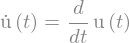

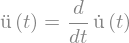

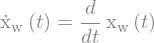

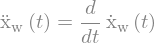

In [4]:
x0_w = Function("{x}_w", )
x1_w = Function("{\dot{x}_w}")
x2_w = Function("{\ddot{x}_w}")
u0 = Function("{u}")
u1 = Function("{\dot{u}}")
u2 = Function("{\ddot{u}}")

# here _w is being used as a placeholder for the eventual v and h.

alpha_w, beta_w, gamma_w, phi_w, xi_w = symbols("alpha_w, beta_w, gamma_w, phi_w, xi_w")

display(Eq(u1(t),diff(u0(t),t)))
display(Eq(u2(t),diff(u1(t),t)))


display(Eq(x1_w(t),diff(x0_w(t),t)))
display(Eq(x2_w(t),diff(x1_w(t),t)))

main_ODE = Eq(x2_w(t), (alpha_w*u2(t) + beta_w*u1(t) + gamma_w*u0(t) - phi_w*x1_w(t) - xi_w*x0_w(t)))

display(main_ODE)



Where $ _w, w \in \{ v, h \} $ (or, potentially, a larger ensemble of tissue types)

# Yen and Nagurka

In [5]:

t, 𝛂, 𝛃, 𝛄, 𝛙, 𝛏, C1, C2, M, J = symbols("t alpha beta gamma phi xi C1 C2  M J")
p_0, p_1, p_2, p_3, p_4, p_5 = symbols("p_0 p_1 p_2 p_3 p_4 p_5")
a_1, b_1 = symbols("a_1, b_1")
t_f = symbols(("t_f"))
j,m,k = symbols("j m k")

P = Function('P')
p = IndexedBase('p')
P = Sum(p[j]*t**j,(j,0,5))#sympy chokes on all of these


λ = Function('lamda')
a = IndexedBase('a')
b = IndexedBase('b')

λ = Sum(a[m] * cos(2 * m * pi * t / t_f), (m, 1, M)) + Sum(b[m] * sin(2 * m * pi * t / t_f), (m, 1, M))

# sympy.pprint(λ)
# sympy.pprint(diff(λ, t))
# sympy.pprint(diff(λ, t, t))

X = P + λ

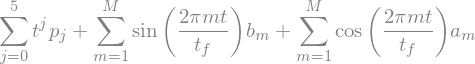

In [6]:
X

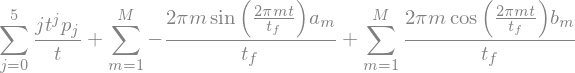

In [7]:
diff(X , t)

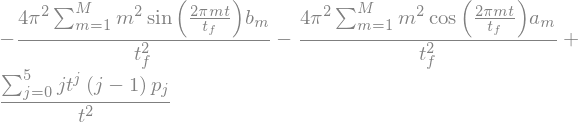

In [8]:
diff(X , t, t)

# Method of undetermined coefficients


In the inverse-dynamic use by Yen&Nagurka,
the fourier series + polynomial define one time-course of one of the x outputs.

We want to obtain the u control input (and the other x output, of course), and then
the cost function J.

Unfortunately, both sympy and maxima choke on solving the DE for U after the fourier series,
even though this DE really should be analytic.

One could easily numerically integrate the problem, as discussed in one of Nagurka and Yen's examples
 - but that's boring and kinda defeats the purpose of using this high-accuracy analytic parametrization.

```
x2_v = 𝛂ᵥ*u2 + 𝛃ᵥ*u1 + 𝛄ᵥ*u0 - 𝛙ᵥ*x1_v - 𝛏ᵥ*x0_v




d²xᵥ/dt² = 𝛂*d²u/dt² + 𝛃*du/dt + 𝛄*u - 𝛙*dxᵥ/dt - 𝛏*xᵥ
𝛏*xᵥ = 𝛂*d²u/dt² + 𝛃*du/dt + 𝛄*u - 𝛙*dxᵥ/dt - d²xᵥ/dt²


𝛏xᵥ = 𝛂ü + 𝛃u̇ + 𝛄u - 𝛙ẋᵥ - ẍᵥ
```

We approximate xᵥ by Nagurka, Eq. 13:

```
xᵥ(t) = P(t) + λ(t)

    5
P = ∑ p_j
   j=0

    M
λ = ∑ a cos + b sin
   m=1
```

there is a subtlty here in that the derivative of a fourier series may not equal the term-by-term derivative.
https://math.stackexchange.com/questions/1754033/integration-and-differentiation-of-fourier-series
this is explicitly addressed in nagurka. this might be why the CASes choked - the terms that
ensure differentiability weren't known to it

```
𝛂ü + 𝛃u̇ + 𝛄u = 𝛏(P + λ)  + 𝛙ẋᵥ + ẍᵥ
```

now that's nothing more than the harmonic oscillator.

http://web.uvic.ca/~monahana/ode_1_flowchart.pdf
http://web.uvic.ca/~monahana/ode_2_flowchart.pdf
a brilliant ode flowchart!

this is a nonhomogenous differential equation.
Is the ODE linear? Yes.

```
𝛂ü + 𝛃u̇ + 𝛄u = 𝛏(P + λ) + 𝛙d(P + λ)/dt + d²(P + λ)/dt²
```
let us put it in standard form:

```
ü + 𝛃/𝛂u̇ + 𝛄/𝛂u = (𝛏/𝛂)(P + λ) + (𝛙/𝛂)d(P + λ)/dt + (1/𝛂)d²(P + λ)/dt²
```

The ODE is non-homogeneous.

> "The solution is of form y(x) = yp(x) + yc(x) where yp(x) is a particular solution and yc(x) is
the solution of the associated homogeneous ODE."

> "Find yc(x) by going back to Step 1." Homogeneous ODE:

```
ü + 𝛃/𝛂u̇ + 𝛄/𝛂u = 0
```

define two new constants,

```
A = 𝛃/𝛂
B = 𝛄/𝛂
```

typical values for

```
𝛂=1.3e-08
𝛃=5.7
𝛄=4e7
```
```
A² - 4B = 1e17
```

therefore, case A:


> yc(t) = c₁e^(m₁t) + c₂e^(m₂t)


(I knew I would mess up beta and B, man, lack of CAS is hurting).

(spoiler alert: We actually didn't need yc at all, it seems)

> "Is g(x) a sum/product of constants, polynomials, exponentials, and sine/cosine
functions?" 

Yes.

> "Can find yp(x) using method of undetermined coefficients. Let the functions hi(x) be made
up of the functions in g(x) and their derivatives. 
> Do any of the hi(x) belong to the fundamental set y1(x), y2(x) of the homogeneous ODE?"

https://tutorial.math.lamar.edu/classes/de/undeterminedcoefficients.aspx


# Pore formation

**[previously at transmembrane_lib.py and nagurka_math_2.py]**

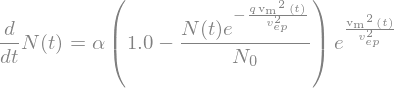

In [9]:
v_m,alpha,N0,q,v_ep, N_ic = symbols("v_m,alpha,N0,q,v_ep, N_ic", real=True)
N = Function('N')
v_m = Function('v_m')(t)

# v_m = sympy.simplify(solution.rhs)

k = (v_m/v_ep)**2

LHS = diff(N(t),t)
RHS = alpha * exp(k) * (1.0 - (N(t)/N0)*exp(-q*k))

dN_dt = Eq(LHS, RHS)

# adding W(t_f): W_tf, W(t).diff(t,1).subs(t,t_f): d_W_tf}
# raises ValueError: Couldn't solve for initial conditions

# sympy.pprint(sympy.simplify(solution))
display(dN_dt)

Strictly for the cost function, this can perhaps be simplified to 


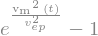

In [10]:
exp(k) - 1

# Pore current

where $\text{v}_m$ is the normalized version

If I'm not mistaken,  DeBruin 1999 has a typo:

$$ I_{ep} = e^{V_m - 1}$$

compared to eq. 14 in Talele 2007. Compare to DeBruin in Electroporation1998, and eq. 2.23 in Talele's thesis.

$$ I_{ep} = e^{V_m}-1 $$

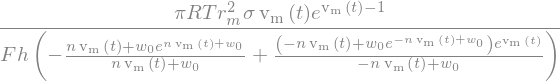

In [11]:
w0,F,R,T,r_m,diameter,h,sigma,n,N,k = symbols("w0,F,R,T,r_m,diameter,h,sigma,n,N,k")
v_m = Function('v_m')

#v_m = (V_m(t)) * (F/(R*T))

v_m = v_m(t)

i_ep_term_1 = (pi * (r_m**2) * sigma * v_m * R * T) / (F * h)

i_ep_term_2_divisor_1 = exp(v_m)*((w0*exp(w0-n*v_m) - (n*v_m)) / (w0 - (n*v_m)))
i_ep_term_2_divisor_2 = -((w0*exp(w0+n*v_m) + (n*v_m)) / (w0 + (n*v_m)))
i_ep_term_2 = exp(v_m - 1) / (i_ep_term_2_divisor_1 + i_ep_term_2_divisor_2)

i_ep = i_ep_term_1 * i_ep_term_2

i_ep

For nondimensionalization, perhaps simplify to exponential increase to solution conductivity?

$$ I_{ep} = \lambda_o \left(1-e^{-x}\right) $$

## Incorrect pore implementation

capacitor 

In [12]:

# I = C_m dv/dt
# dv_dt = I/C_m
# permittivity already has the eps0 in it
A = 4*pi*(diameter/2)**2
C_m = k * A / h
dV_dt_ep = -(i_ep * N / C_m)

# I_ep # Requires sage

In [13]:
# print(I_ep.diff(t)) # Requires sage

In [14]:
# print(simplify(simplify((I_ep.diff(t))._sage_())))#.canonicalize_radical() # Requires sage

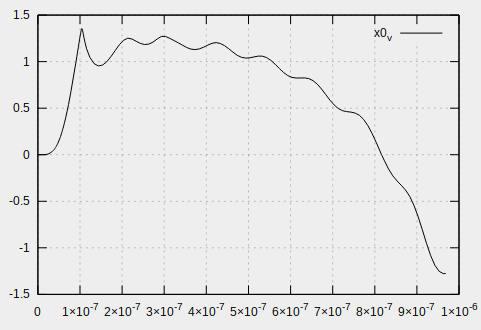



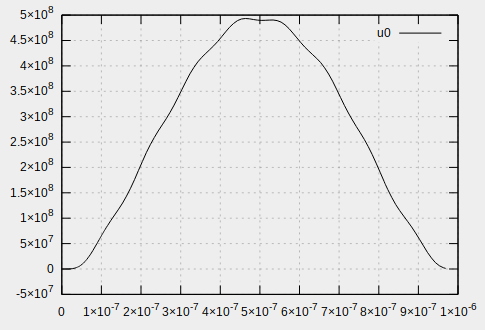

Though the initial "snap" is correctly represented, the decay of x0v below 0 on the falling edge is clearly just wrong. 

# Correct pore formation formulation

As specified by Talele et al, the correct operation is to update the membrane conductivity (and therefore the coefficients) on each step.

Conductivity (or "Specific conductance") has units S/m . 

$$g_p \text{ (Siemens)} = I_{ep}/V_m$$

Cell area is 

$$ A = 4 \pi R^2 $$

$$ \sigma_{ep} = \lambda_{ep} = \frac{h}{A} \frac{I_{ep}}{V_m} $$

$$ \sigma = 1 / \rho$$

Regrettably, this transforms the system of ODEs from an LTI to a time-varying one, 

In [15]:
I_ep, lambda_ep, temp = symbols("I_ep lambda_ep temp")


# want to split out all the alpha etc coeffs with l_m_ep so we don't need to re-calculate 
# a_1,..... every step

# lambda_ep = (I_ep / x0_w(t))
l_m_ep = l_m + lambda_ep

l_m_ep

In [16]:
# talele switch terms from g p to sigma p at eq 17 - is there a conversion happening there?

# I_ep = (i_ep * N)

print("# Generated via transmembrane_math.ipynb")
for idx, term in enumerate([alpha, beta, gamma, xi, phi]):
    term_ep = term.subs(l_m, l_m_ep)
    term_ep = term_ep.expand().coeff(lambda_ep, 1).simplify()
    print("#")
    term_ep = str(term_ep).replace("epsilon", "e").replace("lambda", "l")
#     term_ep = "\n".join(textwrap.wrap(term_ep,80))
    term_ep = textwrap.fill(term_ep,
                    initial_indent='',
                    subsequent_indent=' ' * 4,
                    width=80,
                    )

    print("self."+["alpha_ep", "beta_ep", "gamma_ep", "xi_ep", "phi_ep"][idx], "=", term_ep)
    print("#")

# Generated via transmembrane_math.ipynb
#
self.alpha_ep = 0
#
#
self.beta_ep = 3*R*d**2*e_o*(3*R - d)/(3.0*R**3*e_i*e_m + 6*R**3*e_m*e_o - 6*R**2*d*e_i*e_m +
    6*R**2*d*e_i*e_o + 6*R**2*d*e_m**2 - 6*R**2*d*e_m*e_o + 6*R*d**2*e_i*e_m -
    6*R*d**2*e_i*e_o - 6*R*d**2*e_m**2 + 6*R*d**2*e_m*e_o - 2*d**3*e_i*e_m +
    2*d**3*e_i*e_o + 2*d**3*e_m**2 - 2*d**3*e_m*e_o)
#
#
self.gamma_ep = 3*R*d**2*l_o*(3*R - d)/(3.0*R**3*e_i*e_m + 6*R**3*e_m*e_o - 6*R**2*d*e_i*e_m +
    6*R**2*d*e_i*e_o + 6*R**2*d*e_m**2 - 6*R**2*d*e_m*e_o + 6*R*d**2*e_i*e_m -
    6*R*d**2*e_i*e_o - 6*R*d**2*e_m**2 + 6*R*d**2*e_m*e_o - 2*d**3*e_i*e_m +
    2*d**3*e_i*e_o + 2*d**3*e_m**2 - 2*d**3*e_m*e_o)
#
#
self.xi_ep = (3.0*R**3*l_i + 6*R**3*l_o - 6*R**2*d*l_i + 12*R**2*d*l_m - 6*R**2*d*l_o +
    6*R*d**2*l_i - 12*R*d**2*l_m + 6*R*d**2*l_o - 2*d**3*l_i + 4*d**3*l_m -
    2*d**3*l_o)/(3.0*R**3*e_i*e_m + 6*R**3*e_m*e_o - 6*R**2*d*e_i*e_m +
    6*R**2*d*e_i*e_o + 6*R**2*d*e_m**2 - 6*R**2*d*e_m*e_o + 6*R*d**2*e_i*e_m -
    6

These coefficients reflect how the alpha ... coefficients need to change correspondning to membrane electroporation.

Talele use a a 15 um cell as (4 * pi * (15e-6)^2) / (pi * (0.79e-9 )^2) = 1.5e9 equilibrium pore density
does that mean the virus's equilibirium pore density should be lower?

## Hey, wouldn't the permittivity change too?

# Nondimensionalization, attempt 2

- Scale all terms in the virus by the ratio of the diameter?

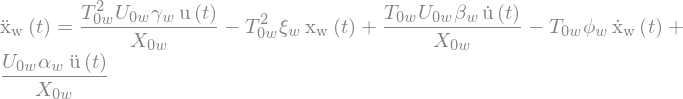

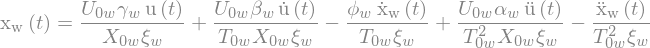

In [17]:

T0_w, U0_w, X0_w = symbols("T0_w, U0_w, X0_w")

main_ODE_nondim = Eq(x2_w(t), ((1/(T0_w*T0_w))*U0_w*alpha_w*u2(t) + (1/T0_w)*U0_w*beta_w*u1(t) + U0_w*gamma_w*u0(t) 
                                            - (1/T0_w)*X0_w*phi_w*x1_w(t) - X0_w*xi_w*x0_w(t)) / (X0_w * (1/(T0_w*T0_w))))

display(main_ODE_nondim.expand())

# # T0,,etc correction factors need to be added here in this step.
main_x0_ode_nondim = sympy.solve(main_ODE_nondim,x0_w(t))[0]

display(Eq(x0_w(t), main_x0_ode_nondim.expand()))

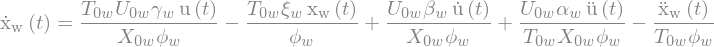

In [18]:
main_x1_ode_nondim = sympy.solve(main_ODE_nondim,x1_w(t))[0]
display(Eq(x1_w(t), main_x1_ode_nondim.expand()))

In [19]:
# xw = U0_v * u(t) * virus.gamma / (X0_v * virus.xi)

T0 = 1e-6

X0_v = 1.0
U0_v = virus.xi / virus.gamma

virus_x0_ode_nondim = main_x0_ode_nondim.subs([(alpha_w, virus.alpha), (beta_w, virus.beta),
                            (gamma_w, virus.gamma),(phi_w, virus.phi),(xi_w, virus.xi),
                                (U0_w, U0_v), (T0_w, T0), (X0_w, X0_v)])
# display(sympy.solve(main_ODE,x0_w(t)))

virus_substituted_x0_ode_nondim = Eq(x0_w(t), virus_x0_ode_nondim)

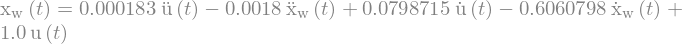

In [20]:
sympy_round(Eq(x0_w(t), virus_x0_ode_nondim))

In [21]:
U0_h = host_cell.xi / host_cell.gamma
X0_h = 1.0

virus_coefficient_substitutions = [(alpha_w, virus.alpha), (beta_w, virus.beta),
                            (gamma_w, virus.gamma),(phi_w, virus.phi),(xi_w, virus.xi)]
host_coefficient_substitutions = [(alpha_w, host_cell.alpha), (beta_w, host_cell.beta),
                            (gamma_w, host_cell.gamma),(phi_w, host_cell.phi), (xi_w, host_cell.xi)]

host_x0_ode_nondim = main_x0_ode_nondim.subs([(alpha_w, host_cell.alpha), (beta_w, host_cell.beta),
                            (gamma_w, host_cell.gamma),(phi_w, host_cell.phi), (xi_w, host_cell.xi),
                               (U0_w, U0_h), (T0_w, T0), (X0_w, X0_h)])
# display(sympy.solve(main_ODE,x0_w(t)))



host_substituted_x0_ode_nondim = Eq(x0_w(t), host_x0_ode_nondim)

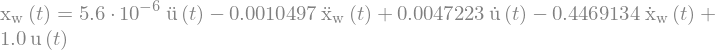

In [22]:
sympy_round(Eq(x0_w(t), host_x0_ode_nondim))

Note the difference in u derivative term scales!

# Surface conductance

Grosse and Schwan 1992 eq 12, assuming no bulk membrane conductance, in the DC case when omega = 0

simplify(E_f / (1 + ((1/(sigma_o)) * G_s / R)))

\frac{E_{f} R \sigma_{o}}{G_{s} + R \sigma_{o}}

In [23]:
sigma_o = 0.2
rho_a = 1/sigma_o # S/m - subscript rho_a is the extracellular electrolyte
# G_m = 1 # S/(m^2) membrane specific conductance
G_s = 10e-9  # S surface conductance
R = 50e-9

surface_conductance_DC_factor = 1 / (1 + (rho_a * G_s / R))

surface_conductance_DC_factor

# Logistic function derivative

In [24]:
k, x, k0, peak = symbols("k, x, k0, peak")

logistic = peak / (1+exp(-(k * (x-k0))))

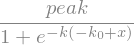

In [25]:
logistic

In [26]:
sympy.julia_code(logistic.diff(x))

'k.*peak.*exp(-k.*(-k0 + x))./(1 + exp(-k.*(-k0 + x))).^2'

In [27]:
sympy.julia_code(logistic.diff(x,x))

'-k.^2.*peak.*(1 - 2*exp(k.*(k0 - x))./(exp(k.*(k0 - x)) + 1)).*exp(k.*(k0 - x))./(exp(k.*(k0 - x)) + 1).^2'

# Simple Fourier Transform

after not having much luck with the fourier parametrization, let's try finding the single frequency that maximizes the ratio. Contrary to intuition, a sine wave can induce a membrane response, despite the 

> Cell Fusion and Cell Poration by Pulsed RadioFrequency Electric Fields Donald C. Chang

using the SciPy definition of the FT, f denoting frequency in Hz:

$$\hat{M}(k) = \int_{-\infty}^{\infty} M(x)\ e^{-2\pi i x f}\,dx$$

$$ F(f)=2\pi i f\cdot F(f). $$ 

(FT of cos(2 pi A f) is just 0.5x the delta function at f=A, so as a transfer function this can be neglected.)

\mathcal{

https://www.thefouriertransform.com/applications/differentialequations.php

(an easier method would probably be to just do this from the transfer function directly)

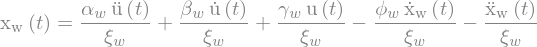

In [28]:
main_x0_ode = sympy.solve(main_ODE,x0_w(t))[0]
display(Eq(x0_w(t), main_x0_ode.expand()))

In [29]:
f, k = symbols("f, k")
X_w = Function("X_w")
X_v = Function("X_v")
X_h = Function("X_h")
U = Function("U")

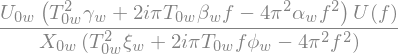

In [30]:
fourier_const = 2 * pi * I * f

FT_x0_ode = Eq(x0_w(t), main_x0_ode_nondim).subs([(u0(t), U(f)), (u1(t), fourier_const*U(f)),(u2(t), fourier_const*fourier_const*U(f)),
                  (x0_w(t), X_w(f)), (x1_w(t), fourier_const*X_w(f)), (x2_w(t), fourier_const*fourier_const*X_w(f))]).expand()

FT_x0_ode = sympy.solve(FT_x0_ode, X_w(f))[0]

FT_x0_ode

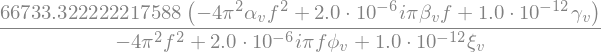

In [49]:
alpha_v, beta_v, gamma_v, phi_v, xi_v = symbols("alpha_v, beta_v, gamma_v, phi_v, xi_v")

#override
U0_v = U0_h

FT_virus_x0_ode = FT_x0_ode.subs([(alpha_w, alpha_v), (beta_w, beta_v),
                            (gamma_w, gamma_v),(phi_w, phi_v),(xi_w, xi_v), (U0_w, U0_v), (T0_w, T0), (X0_w, X0_v)])

# FT_virus_x0_ode = FT_virus_x0_ode.subs(U(f),sympy.DiracDelta(f-k)) #okay, now this is just silly and unnecessary wrangling.
FT_virus_x0_ode = FT_virus_x0_ode.subs(U(f), 1)

FT_virus_x0_ode 

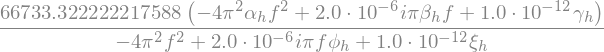

In [50]:
alpha_h, beta_h, gamma_h, phi_h, xi_h = symbols("alpha_h, beta_h, gamma_h, phi_h, xi_h")

FT_host_x0_ode = FT_x0_ode.subs([(alpha_w, alpha_h), (beta_w, beta_h),
                            (gamma_w, gamma_h),(phi_w, phi_h),(xi_w, xi_h), (U0_w, U0_h), (T0_w, T0), (X0_w, X0_h)])

# FT_host_x0_ode = FT_host_x0_ode.subs(U(f),sympy.DiracDelta(f-k)) #okay, now this is just silly and unnecessary wrangling.
FT_host_x0_ode = FT_host_x0_ode.subs(U(f),1)

FT_host_x0_ode

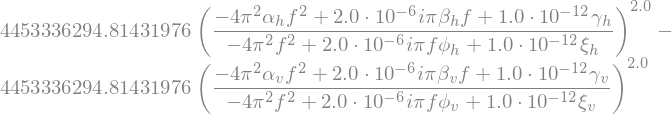

In [51]:
from sympy import oo

J_eq=-X_v(f)**2.0 + X_h(f)**2.0


J_eq = J_eq.subs(X_v(f), FT_virus_x0_ode)
J_eq = J_eq.subs(X_h(f), FT_host_x0_ode)

J = symbols("J")

# T = sympy.solve(, f)


# sympy.solve(Eq(J,J_eq),f**2 + f)

# Oh, we can just use Kotnik's sine TF convolved response equation :(

# J

# print(sympy.diff(FT_virus_x0_ode, f))

# print(sympy.diff(J_eq,f))
J_eq

Even putting into Maxima, while both FTs and diff(FT)s are separately solvable for f, neither a sum cost function X_v(f) nor a X_h(f) are analytically solvable for f

In [52]:
# b = symbols("b") # end time

# J_eq=sympy.integrate(-X_v(f) + X_h(f), (f))  #? wait, what? this integral doesn't make sense.

# J_eq = J_eq.subs(X_v(f), FT_virus_x0_ode)
# J_eq = J_eq.subs(X_h(f), FT_host_x0_ode)

# J_eq

In [53]:
#??? maybe the 

In [54]:
# x = symbols("x") # end time
# sympy.inverse_fourier_transform(FT_virus_x0_ode,f,x)
# doesn't evaluate

In [86]:
# okay, so if we can't analytically differentiate (this works) and set to 0 (this doesn't, can't find the root of the huge thing,
# can't even re-arrange it), can we just plot the frequency response?
def ep_func(V,Vep):
    return np.exp((V**2.0) / (Vep**2.0)) - 1

# J_eq= X_v(f) / X_h(f)

# J_eq= ep_func(X_v(f),0.25) / ep_func(X_h(f),0.25)
# this gives a nice sharp peak

virus_coefficient_substitutions = [(alpha_v, virus.alpha), (beta_v, virus.beta),
                            (gamma_v, virus.gamma),(phi_v, virus.phi),(xi_v, virus.xi)]
host_coefficient_substitutions = [(alpha_h, host_cell.alpha), (beta_h, host_cell.beta),
                            (gamma_h, host_cell.gamma),(phi_h, host_cell.phi), (xi_h, host_cell.xi)]


# J_eq = J_eq.subs(X_v(f), FT_virus_x0_ode)
# J_eq = J_eq.subs(X_h(f), FT_host_x0_ode)
# J_eq = J_eq.subs(virus_coefficient_substitutions)
# J_eq = J_eq.subs(host_coefficient_substitutions)

virus_FT_function = sympy.lambdify(f, FT_virus_x0_ode.subs(virus_coefficient_substitutions), "numpy")
host_FT_function = sympy.lambdify(f, FT_host_x0_ode.subs(host_coefficient_substitutions), "numpy")



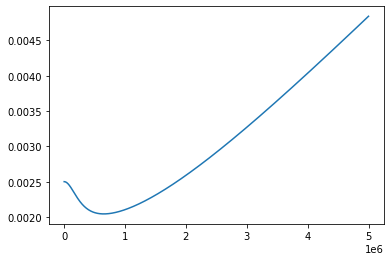

In [87]:
import matplotlib.pyplot as plt
freqs = np.linspace(0.0, 5e6*T0, 1000, dtype=np.float128)
# plt.xscale('log')
plt.plot(freqs/T0, np.abs(virus_FT_function(freqs)/host_FT_function(freqs))) #has no complex part

# Before nondimensionalization was applied, interestingly, switching from subs().evalf() to numpy made this plot "fuzzy". 
# Switching to dtype 128 clearly smoothened the thing up very nicely.
# however, there was still a huge jump discontinuity at about 1e8 that was resolved once nondimensionalization was applied.

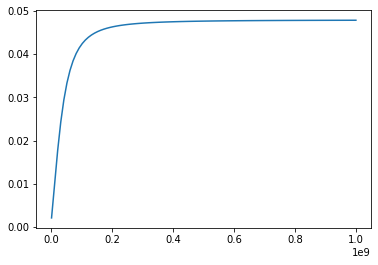

In [88]:
freqs = np.linspace(1e6*T0, 1e9*T0, 100)

plt.plot(freqs/T0, np.abs(virus_FT_function(freqs)/host_FT_function(freqs))) #has no complex part
# plt.plot(freqs/T0, np.abs(np.array([J_eq.subs(f,a).evalf() for a in freqs])))

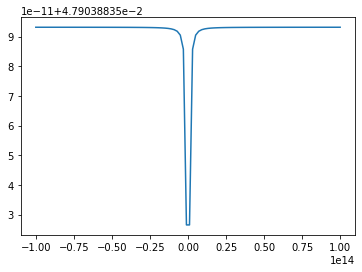

In [90]:
freqs = np.linspace(-1e8, 1e8, 100)
plt.plot(freqs/T0, np.abs(virus_FT_function(freqs)/host_FT_function(freqs))) #has no complex part


In [85]:
# how about two sine components? plot the whole surface? impulse train

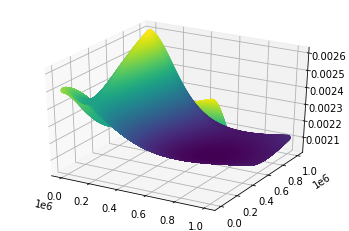

In [106]:
freqs = np.linspace(1*T0, 1e6*T0, 1000)
freqs_x, freqs_y = np.meshgrid(freqs, freqs)

# is this right? can you just sum two FTs to get the 
vir_2fq = np.abs(virus_FT_function(freqs_x) + virus_FT_function(freqs_y)) 
host_2fq = np.abs(host_FT_function(freqs_x) + host_FT_function(freqs_y))

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.scatter(freqs_x/T0, freqs_y/T0, vir_2fq/host_2fq, c=vir_2fq/host_2fq)
plt.show()

So while a sine forcing does put an interesting bound on the signal, I still think we can do better variationally.

there are a few examples of path integrals of harmonic oscillators, might be useful